# Imports

In [1]:
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from torch.utils.data import DataLoader, TensorDataset
import joblib
import matplotlib.pyplot as plt # type: ignore
import mlflow
import mlflow.sklearn
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim


# Import the data

In [2]:
import_normalized = True
os.chdir('..')
data = pd.read_csv('data\processed\processed_data.csv') if not import_normalized else pd.read_csv('data\processed\processed_normalized_data.csv')
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.326221,-0.901886,-1.095988,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,1
1,-0.440036,1.515067,-1.095988,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,0
2,-1.536794,-0.901886,-1.095988,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,1
3,0.501521,-0.901886,-1.095988,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,0
4,2.063884,1.515067,-1.095988,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,-0.901886,0.912419,0.007457,-0.004426,-1.225848,0.807737,0.646092,-1.030670,-0.066419,0
9996,-1.391939,-0.901886,0.912419,-0.373958,1.724464,-0.306379,-0.911583,0.646092,0.970243,0.027988,0
9997,0.604988,-0.901886,-1.095988,-0.278604,0.687130,-1.225848,-0.911583,-1.547768,0.970243,-1.008643,1
9998,1.256835,0.306591,0.912419,0.293517,-0.695982,-0.022608,0.807737,0.646092,-1.030670,-0.125231,1


## Splitting the data

In [3]:
features = data.iloc[:, :-1]
target = data.iloc[:, -1]

In [4]:
features

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.326221,-0.901886,-1.095988,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886
1,-0.440036,1.515067,-1.095988,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534
2,-1.536794,-0.901886,-1.095988,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687
3,0.501521,-0.901886,-1.095988,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918
4,2.063884,1.515067,-1.095988,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276
...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,-0.901886,0.912419,0.007457,-0.004426,-1.225848,0.807737,0.646092,-1.030670,-0.066419
9996,-1.391939,-0.901886,0.912419,-0.373958,1.724464,-0.306379,-0.911583,0.646092,0.970243,0.027988
9997,0.604988,-0.901886,-1.095988,-0.278604,0.687130,-1.225848,-0.911583,-1.547768,0.970243,-1.008643
9998,1.256835,0.306591,0.912419,0.293517,-0.695982,-0.022608,0.807737,0.646092,-1.030670,-0.125231


In [5]:
target

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [6]:
X_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

# Tracking models function

# Building models

In [7]:
mlflow.set_tracking_uri("sqlite:///mlflow.db") 
mlflow.set_experiment("experiment-binario-clasificacion")
def train_and_log_model(model, model_name):
    with mlflow.start_run(run_name=model_name):
        # Entrenamiento y predicción
        model.fit(X_train, y_train)
        y_pred = model.predict(x_test)

        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Loguear hiperparámetros (si están disponibles) y métricas en MLflow
        if hasattr(model, "best_params_"):
            mlflow.log_params(model.best_params_)
        else:
            mlflow.log_param("params", "default")  # Parámetros por defecto si no hay búsqueda de hiperparámetros

        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('f1_score', f1)

        # Guardar el modelo
        mlflow.sklearn.log_model(model, model_name)
        print(f'Model registered in MLflow with accuracy: {accuracy:.4f}')



## Logistic Regression

In [8]:
logistic_regression_model = LogisticRegression()

### Parameters

In [9]:
logistic_regression_param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

### Grid search

In [10]:
grid_search_logistic_regression = GridSearchCV(logistic_regression_model, logistic_regression_param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 1)


### Train

In [11]:
grid_search_logistic_regression.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=1)

In [12]:
best_logistic_regression = grid_search_logistic_regression.best_estimator_
best_logistic_regression

LogisticRegression(C=4.281332398719396, penalty='l1', solver='liblinear')

### Evaluation metrics

In [13]:
y_pred = best_logistic_regression.predict(x_test)

#### Accuracy

In [14]:
accuracy_logistic_regression = accuracy_score(y_test, y_pred)
accuracy_logistic_regression

0.8155

#### Confussion Matrix

In [15]:
confusion_matrix_logistic_regression = confusion_matrix(y_test, y_pred)
confusion_matrix_logistic_regression


array([[1559,   48],
       [ 321,   72]], dtype=int64)

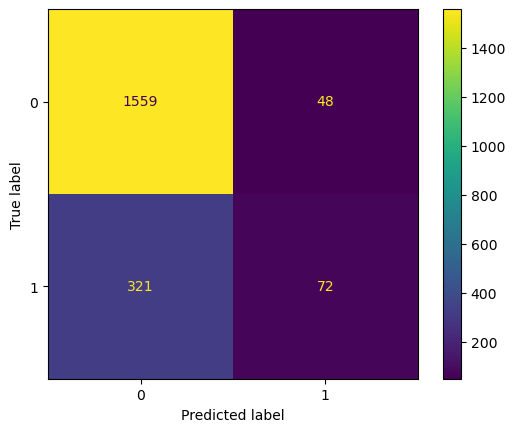

In [16]:
confusion_matrix_display_logistic_regression = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_logistic_regression, display_labels = [0, 1])
confusion_matrix_display_logistic_regression.plot()


#### Classification Report

In [17]:
classification_report_logistic_regression = classification_report(y_test, y_pred)
print(classification_report_logistic_regression)

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.18      0.28       393

    accuracy                           0.82      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.82      0.77      2000



#### AUC

In [18]:
y_pred_prob = best_logistic_regression.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
auc_score

0.7635377032100338

#### ROC curve

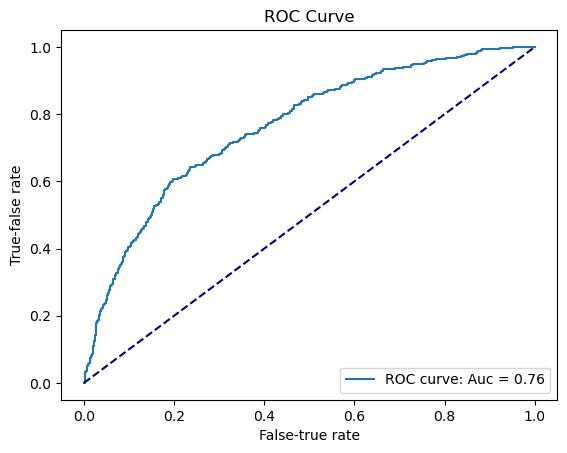

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = f'ROC curve: Auc = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
plt.xlabel('False-true rate')
plt.ylabel('True-false rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')


### Logging the model in mlflow

In [20]:
train_and_log_model(best_logistic_regression, 'Logistic regression')

2024/11/04 11:36:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model registered in MLflow with accuracy: 0.8155


## Random Forest

In [21]:
random_forest_model = RandomForestClassifier()

### Parameters

In [22]:
random_forest_parameters_distributions = {
    'n_estimators': randint(100, 1000),  
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None] + list(np.arange(10, 110, 10)), 
    'min_samples_split': randint(2, 10),  
    'min_samples_leaf': randint(1, 10),  
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False],  
    'class_weight': [None, 'balanced', 'balanced_subsample'], 
    'ccp_alpha': np.linspace(0, 0.1, 10)  
    
}

### Random search

In [23]:
random_forest_random_search = RandomizedSearchCV(
    estimator = random_forest_model,
    param_distributions = random_forest_parameters_distributions,
    n_iter = 100,
    scoring = 'accuracy',
    cv = 5,
    verbose = 2,
    random_state = 42,
)

### Train

In [24]:
random_forest_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, ccp_alpha=0.03333333333333333, class_weight=None, criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END bootstrap=True, ccp_alpha=0.03333333333333333, class_weight=None, criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END bootstrap=True, ccp_alpha=0.03333333333333333, class_weight=None, criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END bootstrap=True, ccp_alpha=0.03333333333333333, class_weight=None, criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   0.0s
[CV] END bootstrap=True, ccp_alpha=0.03333333333333333, class_weight=None, criterion=log_loss, max_depth=100,

c:\Users\mleon\anaconda3\envs\ml_lab\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
205 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
205 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mleon\anaconda3\envs\ml_lab\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mleon\anaconda3\envs\ml_lab\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\mleon\anaconda3\envs\ml_lab\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ]),
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, 10, 2...
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000158E51CA490>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000158E51CA190>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000158E51BFCD0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [25]:
random_forest_random_search.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 934}

In [26]:
random_forest_random_search.best_score_

0.8631249999999999

In [27]:
best_random_forest = random_forest_random_search.best_estimator_

### Evaluation metrics

In [28]:
y_pred = best_random_forest.predict(x_test)

#### Accuracy

In [29]:
accuracy_decision_tree = accuracy_score(y_test, y_pred)
accuracy_decision_tree

0.864

#### Confussion Matrix

In [30]:
confusion_matrix_decision_tree = confusion_matrix(y_test, y_pred)
confusion_matrix_decision_tree

array([[1556,   51],
       [ 221,  172]], dtype=int64)

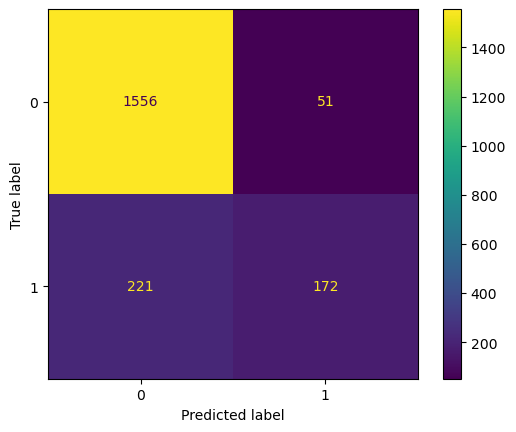

In [31]:
confusion_matrix_display_decision_tree = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_decision_tree, display_labels = [0, 1])
confusion_matrix_display_decision_tree.plot()

#### Classification Report

In [32]:
classification_report_decision_tree = classification_report(y_test, y_pred)
print(classification_report_decision_tree)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.77      0.44      0.56       393

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.86      0.86      0.85      2000



### Logging the model in mlflow

In [33]:
train_and_log_model(best_random_forest, 'Random forest')


2024/11/04 11:57:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model registered in MLflow with accuracy: 0.8645


## Support Vector Machine

In [34]:
support_vector_machine_model = SVC(kernel = 'rbf', random_state = 42)


### Train

In [35]:
support_vector_machine_model.fit(X_train, y_train)

SVC(random_state=42)

### Parameters

In [36]:
svm_parameters = {
    'C': [0.1, 0.05, 0.01, 0.001],
    'gamma': [1, 0.1, 0.01, 0.001]
}

### Grid Search

In [37]:
svm_grid_search = GridSearchCV(support_vector_machine_model, svm_parameters, refit = True, cv = 5, verbose = 1)

In [38]:
svm_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 0.05, 0.01, 0.001],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=1)

In [39]:
svm_best_parameters = svm_grid_search.best_params_

### Evaluation metrics

In [40]:
y_pred = svm_grid_search.predict(x_test)

#### Accuracy

In [41]:
accuracy_svm = accuracy_score(y_test, y_pred)
accuracy_svm

0.84

#### Confusion Matrix

In [42]:
confusion_matrix_svm = confusion_matrix(y_test, y_pred)
confusion_matrix_svm

array([[1588,   19],
       [ 301,   92]], dtype=int64)

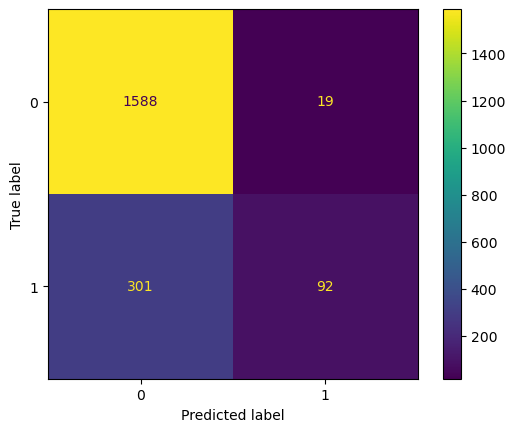

In [43]:
confusion_matrix_svm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_svm, display_labels = [0, 1])
confusion_matrix_svm_display.plot()

#### Classification report

In [44]:
classification_report_svm = classification_report(y_test, y_pred)
print(classification_report_svm)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1607
           1       0.83      0.23      0.37       393

    accuracy                           0.84      2000
   macro avg       0.83      0.61      0.64      2000
weighted avg       0.84      0.84      0.80      2000



### Logging the model in mlflow

In [45]:
train_and_log_model(svm_grid_search, 'Support vector machine (SVM)')


Fitting 5 folds for each of 16 candidates, totalling 80 fits


2024/11/04 12:03:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model registered in MLflow with accuracy: 0.8400


## Neural Network

### Preparing the data tensors

In [46]:
X_train_tensor = torch.tensor(X_train.values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)


### Creating the tensors datasets

In [47]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


### Dataloader using batches

In [48]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)


### Model Architecture

In [49]:
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4):
        super(BinaryClassificationNN, self).__init__()
        # Primera capa oculta
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        
        # Segunda capa oculta
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        
        # Tercera capa oculta
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        
        # Cuarta capa oculta
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()
        
        # Capa de salida
        self.fc5 = nn.Linear(hidden_size4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        x = self.relu4(x)
        
        x = self.fc5(x)
        x = self.sigmoid(x)  # Salida Sigmoid para clasificación binaria
        return x

### Initializating the model and the optimizer

In [50]:
input_size = X_train_tensor.shape[1]  # Número de características de entrada
hidden_size1 = 128  # Tamaño de la primera capa oculta
hidden_size2 = 64   # Tamaño de la segunda capa oculta
hidden_size3 = 32   # Tamaño de la tercera capa oculta
hidden_size4 = 16   # Tamaño de la cuarta capa oculta

model = BinaryClassificationNN(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4)

# BCEWithLogitsLoss para la función de pérdida
criterion = nn.BCEWithLogitsLoss()

# Adam como optimizador
optimizer = optim.Adam(model.parameters(), lr=0.01)


### Train

In [51]:
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for data, labels in train_loader:
        labels = labels.unsqueeze(1)
        #Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch: {epoch + 1}/{epochs}, loss {running_loss/len(train_loader):.4f}')

Epoch: 1/100, loss 0.6962
Epoch: 2/100, loss 0.6931
Epoch: 3/100, loss 0.6931
Epoch: 4/100, loss 0.6931
Epoch: 5/100, loss 0.6931
Epoch: 6/100, loss 0.6931
Epoch: 7/100, loss 0.6931
Epoch: 8/100, loss 0.6931
Epoch: 9/100, loss 0.6931
Epoch: 10/100, loss 0.6931
Epoch: 11/100, loss 0.6931
Epoch: 12/100, loss 0.6931
Epoch: 13/100, loss 0.6931
Epoch: 14/100, loss 0.6931
Epoch: 15/100, loss 0.6931
Epoch: 16/100, loss 0.6931
Epoch: 17/100, loss 0.6931
Epoch: 18/100, loss 0.6931
Epoch: 19/100, loss 0.6931
Epoch: 20/100, loss 0.6931
Epoch: 21/100, loss 0.6931
Epoch: 22/100, loss 0.6931
Epoch: 23/100, loss 0.6931
Epoch: 24/100, loss 0.6931
Epoch: 25/100, loss 0.6931
Epoch: 26/100, loss 0.6931
Epoch: 27/100, loss 0.6931
Epoch: 28/100, loss 0.6931
Epoch: 29/100, loss 0.6931
Epoch: 30/100, loss 0.6931
Epoch: 31/100, loss 0.6931
Epoch: 32/100, loss 0.6931
Epoch: 33/100, loss 0.6931
Epoch: 34/100, loss 0.6931
Epoch: 35/100, loss 0.6931
Epoch: 36/100, loss 0.6931
Epoch: 37/100, loss 0.6931
Epoch: 38/

### Evaluation and accuracy

In [52]:
model.eval()
all_preds = []
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        predicted = (outputs >= 0.5).float()
        all_preds.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_test_tensor, all_preds)
accuracy

0.8035

# Save the model


## Pickle

In [53]:
with open('random_forest.pkl', 'wb') as file:
    pickle.dump(best_random_forest, file)

## Joblib

In [54]:
joblib.dump(best_random_forest, 'random_forest.joblib')

['random_forest.joblib']